In [1]:
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from IPython.display import display
from collections import Counter, defaultdict, OrderedDict
import os
import re
from collections import defaultdict
import operator
from subprocess import call

from bs4 import BeautifulSoup
import urllib.request
from urllib.error import HTTPError

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from IPython.core.debugger import set_trace

# Examine summaries, notes, etc from Chris

In [2]:
# Load data
data = pd.read_csv('/usr2/scratch/fanfic/ao3_detroit_text/stories_ext.csv')
print(len(data))
print(data.columns)

7108
Index(['fic_id', 'title', 'author', 'author_key', 'rating', 'category',
       'fandom', 'relationship', 'character', 'additional tags', 'language',
       'published', 'status', 'status date', 'words', 'comments', 'kudos',
       'bookmarks', 'hits', 'chapter_count', 'series', 'seriespart',
       'seriesid', 'summary', 'preface_notes', 'afterword_notes'],
      dtype='object')


In [3]:
pd.set_option('display.max_colwidth', -1)

In [10]:
# col = 'preface_notes'
col = 'afterword_notes'

data.dropna(subset=[col]).sample(100, random_state=42).loc[:, ['fic_id', 'title', col]]

,fic_id,title,afterword_notes
3780,15446424,Volatile Memory,Connor: We'll be spotted\nHank: Nah\nConnor: We WILL be spotted\nHank: Nnnaaahhh\nChris: Hey guys what's going on over here\nConnor & Hank: ABSOLUTELY NOTHING
5580,15131312,Morning Coffee,"Based on ""Far Too Young to Die"" by Panic! at the Disco.\nIt's going to become super obvious real soon that I have been listening to Panic! non-stop recently, but hey, it's giving me inspiration so I'm rolling with it! This was just a little introductory scene I wanted to do, but the rest of the snippets I've been writing aren't in any sort of chronological order. I thought that instead of writing one long story I'd try writing the scenes as they come to me and see if that helps with writer's block, and it's been working so far!\nAnyway, later chapters will be much more heavily focused on the relationship between the reader and the goofballs who have consumed my life. I love them so much. I'm trash, and I'm not sorry."
4975,15248604,He Prays For Love,"thank you twitter for cursing me with this content\nALSO if you wanna talk about dbh on twitter i made a side twitter specifically for it, @1isblue\nthank you lads"
838,15907977,True North,"It has been literal years since I wrote anything so apologies is the formatting is crap I just wanted to write the story. Hopefully it won't make your eyes bleed.\nAlso if it's OC I apologise, I tried to keep them on target AND it's my first piece of writing to see the light of day so any feedback let me have it :)"
6203,15012635,An Interrupted Reunion,"Wooow, I finally got off my ass and posted something. I swear to God though, I absolutely adore DBH. Sadly I only have a pc and I can’t play it because it’s on PS4, but from the let’s plays I’ve watched if is incredible! I especially love Hank and Connor’s relationship though, if you couldn’t tell ;)\nI don’t see how people can ship them as an actual pairing though, it seems a bit bizarre to me, but hey, ship whatever you want, I won’t judge :D\nThanks for reading! <3 Feedback is appreciated.\nOh and btw, it’s 1am and i just posted this. If it has loads of typos please forgive me because i am tired as fuck and i have been writing this for five hours. I have fixed a few but i’ll fix all of them in the morning if there’s any left."
2834,15615516,爱你到永远 A translation of You Eternally You by ProneToRelapse,译者决定继续放飞自我。肉翻译的好挫请见谅:P 欢迎大家多去原文踩踩。
5785,15090269,Detroit: Remain Human,"So yeah, like I said, first chapter is a bit of a mess! But enjoy! I am very excited for some of the things I have planned"
2497,15667809,To Have A Home,"I hope you enjoyed, I love comments so please let me know how I did! I'm always up for prompt ideas so if you have any for me, then I'm always down for discussing.\nYou can find me on Tumblr! My username is, erialc_raeb (The same as on here to make it easier.)"
4480,15320478,Ol' Faithful,"I can't believe I had to actually write the words ""newspaper tablet"" on here. I'd throw myself off David's Wild Ride if I didn't care for these two guys and their dog so much."
6429,14974367,Wise Men Say,Hello! Took it off my tumblr: @RK-900.


# Prepare sentences for fanfiction word2vec training

## Word tokenization

In [2]:
import spacy
nlp = spacy.load('en')

In [5]:
# Load fanfiction data
fandoms = [
    'academia',
    'allmarvel',
    'detroit',
    'friends',
]

data_fpath = '/usr0/home/mamille2/erebor/fanfiction-project/data/ao3/{0}/ao3_{0}_sentences.txt'

for f in fandoms:
    print(f)
    with open(data_fpath.format(f)) as file_obj:
        sentences = file_obj.read().splitlines()
        sent_toks = []
        for sent in tqdm(sentences):
            sent_toks.append([tok.text for tok in nlp.tokenizer(sent.lower())])
    with open(data_fpath + '.tokens', 'w') as wfile:
        for sent_tok in sent_toks:
            wfile.write(' '.join(sent_tok) + '\n')

academia


KeyboardInterrupt: 

## Sentence tokenization

In [5]:
from nltk.tokenize import sent_tokenize

# Load fanfiction data
fandoms = [
    'academia',
    'allmarvel',
    'detroit',
    'friends',
]

data_dirpath_template = '/usr2/scratch/fanfic/ao3_{}_text/stories'
output_fpath = '/usr2/mamille2/fanfiction-project/data/ao3_{}_sentences.txt'

for f in fandoms:
    print(f)
    fandom_dirpath = data_dirpath_template.format(f)
    
    with open(output_fpath, 'a') as f:
        for fname in tqdm(os.listdir(fandom_dirpath)):
            paras = pd.read_csv(os.path.join(fandom_dirpath, fname))['text'].tolist()
            for para in paras:
                sents = sent_tokenize(para)
                for sent in sents:
                    f.write(sent)

academia


KeyboardInterrupt: 

In [4]:
story = pd.read_csv('/usr2/scratch/fanfic/ao3_allmarvel_text/stories/1539965_0001.csv')
story.columns

Index(['fic_id', 'chapter_id', 'para_id', 'text'], dtype='object')

# Get list of most popular fandoms on AO3

In [2]:
cat_urls = [
    'https://archiveofourown.org/media/Anime%20*a*%20Manga/fandoms',
    'https://archiveofourown.org/media/Books%20*a*%20Literature/fandoms',
    'https://archiveofourown.org/media/Cartoons%20*a*%20Comics%20*a*%20Graphic%20Novels/fandoms',
    'https://archiveofourown.org/media/Movies/fandoms',
    'https://archiveofourown.org/media/Other%20Media/fandoms',
    'https://archiveofourown.org/media/Theater/fandoms',
    'https://archiveofourown.org/media/TV%20Shows/fandoms',
    'https://archiveofourown.org/media/Video%20Games/fandoms',
           ]

In [5]:
def get_top_fandoms(list_url):

    soup = BeautifulSoup(urllib.request.urlopen(list_url).read(), 'html.parser')

    fandoms_uls = soup.find_all("ul", {"class": "tags index group"})
    fandoms_list = []
    for ul in fandoms_uls:
    #     fandoms_list.extend([(re.search(r'\n(.*?)\n', el.text).group(1), int(re.search(r'\((\d+)\)', el.text).group(1))) for el in ul.find_all('li')])
        fandoms_list.extend([(re.search(r'\n(.*?)\n', el.text).group(1), int(re.search(r'\((\d+)\)', el.text.strip()[-10:]).group(1))) for el in ul.find_all('li')])
    #     fandoms_list.extend([el.text.strip() for el in ul.find_all('li')])
    # fandoms_list = soup.find_all("a", {"class": "tag"})

    fandoms_sorted = sorted(fandoms_list, key=operator.itemgetter(1), reverse=True)
    return fandoms_sorted

In [9]:
all_fandoms = []
for fl in cat_urls:
    all_fandoms += get_top_fandoms(fl)
    all_fandoms_sorted = sorted(list(set(all_fandoms)), key=operator.itemgetter(1), reverse=True)
    
print(len(all_fandoms_sorted))
all_fandoms_sorted[:100]

23293


[('Marvel', 256153),
 ('Marvel Cinematic Universe', 232803),
 ('Supernatural', 187764),
 ('Harry Potter - J. K. Rowling', 176531),
 ('The Avengers - Ambiguous Fandom', 124777),
 ('The Avengers (Marvel) - All Media Types', 121788),
 ('DCU', 119703),
 ('Sherlock Holmes & Related Fandoms', 115647),
 ('Sherlock (TV)', 106048),
 ('The Avengers (Marvel Movies)', 103281),
 ('Teen Wolf (TV)', 95696),
 ('Star Wars - All Media Types', 76346),
 ('Captain America - All Media Types', 68356),
 ('Doctor Who & Related Fandoms', 62240),
 ('Doctor Who & Related Fandoms', 62239),
 ('Video Blogging RPF', 61232),
 ('Captain America (Movies)', 61204),
 ('TOLKIEN J. R. R. - Works & Related Fandoms', 56113),
 ('Dragon Age - All Media Types', 55505),
 ('Star Trek', 53399),
 ('Voltron: Legendary Defender', 51002),
 ('Dragon Age (Video Games)', 49045),
 ('Doctor Who', 48945),
 ('Haikyuu!!', 47415),
 ('MS Paint Adventures', 46273),
 ('Homestuck', 46156),
 ('Original Work', 45886),
 ('Stargate - All Media Types', 

In [13]:
all_fandoms_sorted[:35]

[('Marvel', 256153),
 ('Marvel Cinematic Universe', 232803),
 ('Supernatural', 187764),
 ('Harry Potter - J. K. Rowling', 176531),
 ('The Avengers - Ambiguous Fandom', 124777),
 ('The Avengers (Marvel) - All Media Types', 121788),
 ('DCU', 119703),
 ('Sherlock Holmes & Related Fandoms', 115647),
 ('Sherlock (TV)', 106048),
 ('The Avengers (Marvel Movies)', 103281),
 ('Teen Wolf (TV)', 95696),
 ('Star Wars - All Media Types', 76346),
 ('Captain America - All Media Types', 68356),
 ('Doctor Who & Related Fandoms', 62240),
 ('Doctor Who & Related Fandoms', 62239),
 ('Video Blogging RPF', 61232),
 ('Captain America (Movies)', 61204),
 ('TOLKIEN J. R. R. - Works & Related Fandoms', 56113),
 ('Dragon Age - All Media Types', 55505),
 ('Star Trek', 53399),
 ('Voltron: Legendary Defender', 51002),
 ('Dragon Age (Video Games)', 49045),
 ('Doctor Who', 48945),
 ('Haikyuu!!', 47415),
 ('MS Paint Adventures', 46273),
 ('Homestuck', 46156),
 ('Original Work', 45886),
 ('Stargate - All Media Types', 

In [10]:
# Save sorted fandoms
with open('/usr2/mamille2/fanfiction-project/ao3_top_fandoms.tsv', 'w') as f:
    for name, count in all_fandoms_sorted:
        f.write(f'{name}\t{count}\n')

In [23]:
n = 100

top_n = fandoms_sorted[:n]
top_n

[('Harry Potter - J. K. Rowling', 174185),
 ('Sherlock Holmes & Related Fandoms', 115154),
 ('Star Wars - All Media Types', 75226),
 ('TOLKIEN J. R. R. - Works & Related Fandoms', 55783),
 ('Dragon Age - All Media Types', 55125),
 ('Doctor Who', 48665),
 ('A Song of Ice and Fire & Related Fandoms', 33336),
 ('Arthurian Mythology & Related Fandoms', 33167),
 ('The Hobbit - All Media Types', 29108),
 ('A Song of Ice and Fire - George R. R. Martin', 26077),
 ('The Shadowhunter Chronicles - All Media Types', 23833),
 ('The Lord of the Rings - All Media Types', 20338),
 ('Hannibal Lecter Series - All Media Types', 19172),
 ('Mass Effect - All Media Types', 18666),
 ('Les Misérables - All Media Types', 18105),
 ('Percy Jackson and the Olympians & Related Fandoms - All Media Types',
  16336),
 ('Star Wars: Rebellion Era - All Media Types', 15994),
 ('RIORDAN Rick - Works', 14393),
 ('Star Wars: Rise of Empire Era - All Media Types', 13493),
 ('Dangan Ronpa - All Media Types', 13290),
 ('The L

# Scrape list of book-based fandoms on AO3, sort by popularity

## Scrape from list of fandoms

In [55]:
already_scraped = [
    'Harry Potter - J. K. Rowling',
    'Percy Jackson and the Olympians - Rick Riordan',
    'Hunger Games Series - All Media Types',
    'Twilight Series - Stephenie Meyer',
]

In [60]:
base_url = 'https://archiveofourown.org/works?utf8=%E2%9C%93&work_search%5Bsort_column%5D=kudos_count&work_search%5Bother_tag_names%5D=&work_search%5Bexcluded_tag_names%5D=&work_search%5Bcrossover%5D=&work_search%5Bcomplete%5D=T&work_search%5Bwords_from%5D=&work_search%5Bwords_to%5D=&work_search%5Bdate_from%5D=&work_search%5Bdate_to%5D=&work_search%5Bquery%5D=&work_search%5Blanguage_id%5D=1&commit=Sort+and+Filter&tag_id={}'
fandoms = [el[0] for el in top_n_filtered if not el[0] in already_scraped]
urls = []
for f in fandoms:
    fandom_url = f.replace(' ', '+').replace('.', '*d*')
    urls.append(base_url.format(fandom_url))
    
commands = []
for f, url in zip(fandoms, urls):
    data_dirpath = '/usr2/mamille2/AO3Scraper/data'
    f_lowered = os.path.join(data_dirpath, f.lower().replace(" ", "_").replace(':', '').replace('/', '_'))
    commands.append(f'python /usr2/mamille2/AO3Scraper/ao3_work_ids.py --out_csv {f_lowered}_ids "{url}"')
    
commands

['python /usr2/mamille2/AO3Scraper/ao3_work_ids.py --out_csv /usr2/mamille2/AO3Scraper/data/a_song_of_ice_and_fire_-_george_r._r._martin_ids "https://archiveofourown.org/works?utf8=%E2%9C%93&work_search%5Bsort_column%5D=kudos_count&work_search%5Bother_tag_names%5D=&work_search%5Bexcluded_tag_names%5D=&work_search%5Bcrossover%5D=&work_search%5Bcomplete%5D=T&work_search%5Bwords_from%5D=&work_search%5Bwords_to%5D=&work_search%5Bdate_from%5D=&work_search%5Bdate_to%5D=&work_search%5Bquery%5D=&work_search%5Blanguage_id%5D=1&commit=Sort+and+Filter&tag_id=A+Song+of+Ice+and+Fire+-+George+R*d*+R*d*+Martin"',
 'python /usr2/mamille2/AO3Scraper/ao3_work_ids.py --out_csv /usr2/mamille2/AO3Scraper/data/the_lord_of_the_rings_-_all_media_types_ids "https://archiveofourown.org/works?utf8=%E2%9C%93&work_search%5Bsort_column%5D=kudos_count&work_search%5Bother_tag_names%5D=&work_search%5Bexcluded_tag_names%5D=&work_search%5Bcrossover%5D=&work_search%5Bcomplete%5D=T&work_search%5Bwords_from%5D=&work_search

In [42]:
top_n_filtered

[('Harry Potter - J. K. Rowling', 174185),
 ('A Song of Ice and Fire - George R. R. Martin', 26077),
 ('The Lord of the Rings - All Media Types', 20338),
 ('Star Wars: Rebellion Era - All Media Types', 15994),
 ('Star Wars: Rise of Empire Era - All Media Types', 13493),
 ('The Lord of the Rings - J. R. R. Tolkien', 12786),
 ('Percy Jackson and the Olympians - Rick Riordan', 11590),
 ('The Shadowhunter Chronicles - Cassandra Clare', 9963),
 ('The Vampire Diaries & Related Fandoms', 9947),
 ('The Silmarillion and other histories of Middle-Earth - J. R. R. Tolkien',
  9754),
 ('Hunger Games Series - All Media Types', 9655),
 ('The Hobbit - J. R. R. Tolkien', 9280),
 ('The Mortal Instruments Series - Cassandra Clare', 7891),
 ('The Heroes of Olympus - Rick Riordan', 7300),
 ('Guardians of Childhood & Related Fandoms', 7211),
 ('Hunger Games Trilogy - Suzanne Collins', 7086),
 ('Star Wars Legends - All Media Types', 6467),
 ('Carmilla - All Media Types', 6176),
 ('Les Misérables - Victor Hu

## Select fandoms

In [3]:
list_url = 'https://archiveofourown.org/media/Books%20*a*%20Literature/fandoms'

# html = str(urllib.request.urlopen(list_url).read())
# html
soup = BeautifulSoup(urllib.request.urlopen(list_url).read(), 'html.parser')
soup

<!DOCTYPE html>

<html lang="en">
<head>
<meta charset="utf-8"/>
<meta content="ie=edge" http-equiv="x-ua-compatible"/>
<script type="text/javascript">window.NREUM||(NREUM={});NREUM.info={"beacon":"bam.nr-data.net","errorBeacon":"bam.nr-data.net","licenseKey":"f2edcff25e","applicationID":"190034","transactionName":"dgwMEkpfWVsHERpUV1sHDQtLH1xZBgZN","queueTime":0,"applicationTime":1426,"agent":""}</script>
<script type="text/javascript">(window.NREUM||(NREUM={})).loader_config={xpid:"VQcCWV9RGwIJVFFRAw=="};window.NREUM||(NREUM={}),__nr_require=function(t,n,e){function r(e){if(!n[e]){var o=n[e]={exports:{}};t[e][0].call(o.exports,function(n){var o=t[e][1][n];return r(o||n)},o,o.exports)}return n[e].exports}if("function"==typeof __nr_require)return __nr_require;for(var o=0;o<e.length;o++)r(e[o]);return r}({1:[function(t,n,e){function r(t){try{s.console&&console.log(t)}catch(n){}}var o,i=t("ee"),a=t(15),s={};try{o=localStorage.getItem("__nr_flags").split(","),console&&"function"==typeof co

In [14]:
fandoms_uls = soup.find_all("ul", {"class": "tags index group"})
fandoms_list = []
for ul in fandoms_uls:
#     fandoms_list.extend([(re.search(r'\n(.*?)\n', el.text).group(1), int(re.search(r'\((\d+)\)', el.text).group(1))) for el in ul.find_all('li')])
    fandoms_list.extend([(re.search(r'\n(.*?)\n', el.text).group(1), int(re.search(r'\((\d+)\)', el.text.strip()[-10:]).group(1))) for el in ul.find_all('li')])
#     fandoms_list.extend([el.text.strip() for el in ul.find_all('li')])
# fandoms_list = soup.find_all("a", {"class": "tag"})
print(len(fandoms_list))
fandoms_list

5307


[('1-800-WHERE-R-U Series - Meg Cabot', 5),
 ('1/2 Wangzi | 1/2 Prince', 35),
 ('10 Lb. Penalty - Dick Francis', 1),
 ('100 Books that SHOULD be written - Tyler Adam Smith', 4),
 ('100 Cupboards Series - N. D. Wilson', 1),
 ('The 100 Series - Kass Morgan', 867),
 ('101 Dalmatians - All Media Types', 93),
 ('1066 and All That - W. C. Sellar & R. J. Yeatman', 1),
 ('12 Dancing Princesses (Fairy Tale)', 47),
 ('Les 120 journées de Sodome | The 120 Days of Sodom - Marquis de Sade', 3),
 ('13 Treasures Series - Michelle Harrison', 1),
 ('13 Ways of Looking at a Blackbird - Wallace Stevens', 6),
 ('13 Ways Of Looking at Space Time - Catherynne M. Valente', 1),
 ('15 Ways to Stay Alive - Daphne Gottlieb (Poem)', 3),
 ('1632 Series - Various Authors', 3),
 ('17776: What Football Will Look Like in the Future - Jon Bois', 44),
 ('1984 - George Orwell', 73),
 ('1Q84 - Murakami Haruki', 1),
 ('เดือนเกี้ยวเดือน | 2 Moons - Chiffon_Cake', 37),
 ('221B - Vincent Starrett', 2),
 ('2666 - Roberto Bolañ

In [15]:
fandoms_sorted = sorted(fandoms_list, key=operator.itemgetter(1), reverse=True)
fandoms_sorted

[('Harry Potter - J. K. Rowling', 174185),
 ('Sherlock Holmes & Related Fandoms', 115154),
 ('Star Wars - All Media Types', 75226),
 ('TOLKIEN J. R. R. - Works & Related Fandoms', 55783),
 ('Dragon Age - All Media Types', 55125),
 ('Doctor Who', 48665),
 ('A Song of Ice and Fire & Related Fandoms', 33336),
 ('Arthurian Mythology & Related Fandoms', 33167),
 ('The Hobbit - All Media Types', 29108),
 ('A Song of Ice and Fire - George R. R. Martin', 26077),
 ('The Shadowhunter Chronicles - All Media Types', 23833),
 ('The Lord of the Rings - All Media Types', 20338),
 ('Hannibal Lecter Series - All Media Types', 19172),
 ('Mass Effect - All Media Types', 18666),
 ('Les Misérables - All Media Types', 18105),
 ('Percy Jackson and the Olympians & Related Fandoms - All Media Types',
  16336),
 ('Star Wars: Rebellion Era - All Media Types', 15994),
 ('RIORDAN Rick - Works', 14393),
 ('Star Wars: Rise of Empire Era - All Media Types', 13493),
 ('Dangan Ronpa - All Media Types', 13290),
 ('The L

In [16]:
# Save sorted fandoms
with open('/usr2/mamille2/fanfiction-project/ao3_books_lit.tsv', 'w') as f:
    for name, count in fandoms_sorted:
        f.write(f'{name}\t{count}\n')

In [23]:
n = 100

top_n = fandoms_sorted[:n]
top_n

[('Harry Potter - J. K. Rowling', 174185),
 ('Sherlock Holmes & Related Fandoms', 115154),
 ('Star Wars - All Media Types', 75226),
 ('TOLKIEN J. R. R. - Works & Related Fandoms', 55783),
 ('Dragon Age - All Media Types', 55125),
 ('Doctor Who', 48665),
 ('A Song of Ice and Fire & Related Fandoms', 33336),
 ('Arthurian Mythology & Related Fandoms', 33167),
 ('The Hobbit - All Media Types', 29108),
 ('A Song of Ice and Fire - George R. R. Martin', 26077),
 ('The Shadowhunter Chronicles - All Media Types', 23833),
 ('The Lord of the Rings - All Media Types', 20338),
 ('Hannibal Lecter Series - All Media Types', 19172),
 ('Mass Effect - All Media Types', 18666),
 ('Les Misérables - All Media Types', 18105),
 ('Percy Jackson and the Olympians & Related Fandoms - All Media Types',
  16336),
 ('Star Wars: Rebellion Era - All Media Types', 15994),
 ('RIORDAN Rick - Works', 14393),
 ('Star Wars: Rise of Empire Era - All Media Types', 13493),
 ('Dangan Ronpa - All Media Types', 13290),
 ('The L

In [39]:
# List of non-primary book-based flicks
rm_list = [
    'Star Wars - All Media Types',
    'Dragon Age - All Media Types',
    'Doctor Who',
    'Hannibal Lecter Series - All Media Types',
    'Mass Effect - All Media Types',
    'Dangan Ronpa - All Media Types',
    'James Bond - All Media Types',
    'Star Wars Prequel Trilogy',
    'James Bond (Craig movies)',
    "Assassin's Creed - All Media Types",
    'Star Wars Original Trilogy',
    'Carmilla (Web Series)',
    'The Maze Runner Series - All Media Types',
    'Warcraft - All Media Types',
    '全职高手 - 蝴蝶蓝 | Quánzhí Gāoshǒu - Húdié Lán',
    'Religion & Lore - Ambiguous Fandom',
    'Inspector Morse & Related Fandoms',
    'Fate/stay night & Related Fandoms',
    'Greek and Roman Mythology',
    'Les Misérables - Schönberg/Boublil',
    'Fairy Tales & Related Fandoms',
    'Dungeons & Dragons (Roleplaying Game)',
    'Beauty and the Beast - All Media Types',
    'Love Simon (2018)',
    "Cirque du Freak: The Vampire's Assistant (2009)",
    'Star Wars: The Clone Wars (2008) - All Media Types',
    'Star Wars: Clone Wars (2003) - All Media Types',
    'Jurassic Park - All Media Types',
    'Norse Religion & Lore',
    "Le Fantôme de l'Opéra | Phantom of the Opera & Related Fandoms",
    'Outlander & Related Fandoms',
    'Wiedźmin | The Witcher - All Media Types',
    'Sherlock Holmes & Related Fandoms',
    'Arthurian Mythology & Related Fandoms',
    'A Song of Ice and Fire & Related Fandoms',
    'Les Misérables - All Media Types',
    'Percy Jackson and the Olympians & Related Fandoms - All Media Types',
    'The Shadowhunter Chronicles - All Media Types',
    'Twilight Series - All Media Types',
    'The Hobbit - All Media Types',
]

In [40]:
top_n_filtered = [f for f in top_n if not f[0] in rm_list and not '- Works' in f[0]]
print(len(top_n_filtered))
top_n_filtered

52


[('Harry Potter - J. K. Rowling', 174185),
 ('A Song of Ice and Fire - George R. R. Martin', 26077),
 ('The Lord of the Rings - All Media Types', 20338),
 ('Star Wars: Rebellion Era - All Media Types', 15994),
 ('Star Wars: Rise of Empire Era - All Media Types', 13493),
 ('The Lord of the Rings - J. R. R. Tolkien', 12786),
 ('Percy Jackson and the Olympians - Rick Riordan', 11590),
 ('The Shadowhunter Chronicles - Cassandra Clare', 9963),
 ('The Vampire Diaries & Related Fandoms', 9947),
 ('The Silmarillion and other histories of Middle-Earth - J. R. R. Tolkien',
  9754),
 ('Hunger Games Series - All Media Types', 9655),
 ('The Hobbit - J. R. R. Tolkien', 9280),
 ('The Mortal Instruments Series - Cassandra Clare', 7891),
 ('The Heroes of Olympus - Rick Riordan', 7300),
 ('Guardians of Childhood & Related Fandoms', 7211),
 ('Hunger Games Trilogy - Suzanne Collins', 7086),
 ('Star Wars Legends - All Media Types', 6467),
 ('Carmilla - All Media Types', 6176),
 ('Les Misérables - Victor Hu

In [41]:
# Save sorted fandoms
with open('/usr2/mamille2/fanfiction-project/ao3_books_lit_selected.tsv', 'w') as f:
    for name, count in top_n_filtered:
        f.write(f'{name}\t{count}\n')

# Extract characters from all fandoms for popularity prediction

In [7]:
# Load metadata
fandoms = ['hp']
metadata = {}

for f in fandoms:
    metadata_fpath = f'/usr2/mamille2/AO3Scraper/data/{f}_ao3_metadata.csv'
    metadata[f] = pd.read_csv(metadata_fpath)
    metadata[f]['character_list'] = metadata[f]['character'].fillna('').str.split(',\s+').astype(list)
    
print(len(metadata['hp']))
metadata['hp'].columns

116622


Index(['Unnamed: 0', 'work_id', 'title', 'author_hash', 'rating', 'category',
       'fandom', 'relationship', 'character', 'additional tags', 'language',
       'published', 'status', 'status date', 'words', 'chapters', 'comments',
       'kudos', 'bookmarks', 'hits', 'character_list'],
      dtype='object')

In [37]:
metadata['hp']['fandom']

0         Harry Potter - J. K. Rowling                                                     
1         Harry Potter - J. K. Rowling                                                     
2         Harry Potter - J. K. Rowling                                                     
3         Harry Potter - J. K. Rowling                                                     
4         Harry Potter - J. K. Rowling                                                     
5         Harry Potter - J. K. Rowling                                                     
6         Harry Potter - J. K. Rowling                                                     
7         Harry Potter - J. K. Rowling                                                     
8         Harry Potter - J. K. Rowling                                                     
9         Harry Potter - J. K. Rowling                                                     
10        Harry Potter - J. K. Rowling                                          

In [23]:
# Remove crossovers
metadata['hp']['crossover'] = list(map(lambda x: len([f for f in x.split(',') if not 'Harry Potter' in f and not 'Fantastic Beasts' in f]) > 0, tqdm(metadata['hp']['fandom'])))
# metadata['hp']['crossover'] = map(lambda x: x.split(','), tqdm(fandom_list))
# sum(metadata['hp']['crossover'])
# pd.set_option('display.max_colwidth', -1)
# metadata['hp'].loc[metadata['hp']['crossover']==True, ['fandom', 'crossover']]
metadata['hp'] = metadata['hp'][metadata['hp']['crossover']==False]
len(metadata['hp'])

107508

In [24]:
# Number of characters
f = 'hp'
char_ctr = Counter([char for line in metadata['hp']['character_list'] for char in line if len(char) > 0])
len(char_ctr)

6911

In [25]:
char_ctr.most_common(200)

[('Harry Potter', 40081),
 ('Draco Malfoy', 26110),
 ('Hermione Granger', 22684),
 ('Severus Snape', 18008),
 ('Ron Weasley', 15845),
 ('Remus Lupin', 15434),
 ('Sirius Black', 14949),
 ('Ginny Weasley', 9379),
 ('James Potter', 8936),
 ('Lily Evans Potter', 5387),
 ('Albus Dumbledore', 5288),
 ('Lucius Malfoy', 5213),
 ('Neville Longbottom', 4932),
 ('Luna Lovegood', 4931),
 ('Minerva McGonagall', 4492),
 ('Pansy Parkinson', 4222),
 ('George Weasley', 4018),
 ('Peter Pettigrew', 4004),
 ('Blaise Zabini', 3307),
 ('Scorpius Malfoy', 3301),
 ('Fred Weasley', 3151),
 ('Albus Severus Potter', 2900),
 ('Narcissa Black Malfoy', 2826),
 ('Molly Weasley', 2596),
 ('Teddy Lupin', 2320),
 ('Newt Scamander', 2290),
 ('Voldemort', 2167),
 ('Charlie Weasley', 2070),
 ('Nymphadora Tonks', 2053),
 ('Original Percival Graves', 2040),
 ('Original Female Character(s)', 1985),
 ('James Sirius Potter', 1866),
 ('Tom Riddle', 1787),
 ('Seamus Finnigan', 1762),
 ('Lily Evans', 1743),
 ('Tom Riddle | Voldem

In [40]:
remove_list = [
    'Original Female Character(s)',
    'Original Female Character',
              'Original Male Character(s)',
              'Original Male Character',
              'Original Character',
              'Original Characters',
              'Original Character(s)',
              'OC',
              'OC - Character',
    'Other',
    'Other(s)',
    'Reader'
              ]

In [41]:
def cluster_characters(char_ctr, n_chars):
    ''' 
        n_chars: number of top-frequency characters to keep 
        output: {char: ([names], freq)}, should probably be a namedtuple or separate object
    '''
    clusters = defaultdict(lambda: [[], 0])

    for char, freq in char_ctr.most_common():
        if char in remove_list:
            continue
        if 'Original' in char and 'Character' in char:
            continue
        if 'Original' in char and 'Female' in char:
            continue
        if 'Original' in char and 'Male' in char:
            continue
        new_char = char.replace('Original ', '')
        new_char = re.sub(r'\(.+\)', '', char).strip()
        
        # Figure out if first reference to a charcter, then keep that regardless of how many parts
        
        if ' ' in new_char:
            first_name = new_char.split(' ')[0]
            second_name = new_char.split(' ')[1]
            
            if second_name.endswith("'s"):
                first_name = ' '.join([first_name, second_name])
                second_name = last_name
            
            last_name = new_char.split(' ')[-1]
            if re.match(r'(J|S)r\.?', last_name, re.IGNORECASE):
                last_name = ' '.join(new_char.split(' ')[1:])
                
            if ' '.join([first_name, last_name]) in clusters:
                new_char = ' '.join([first_name, last_name])
                
            if ' '.join([first_name, second_name]) in clusters:
                new_char = ' '.join([first_name, second_name])
                
            else:
                new_char = ' '.join([first_name, second_name])
#                 new_char = char
        
        clusters[new_char][0].append(char)
        clusters[new_char][1] = clusters[new_char][1] + freq

    return sorted(clusters.items(), key=lambda x: x[1][1], reverse=True)[:n_chars]

In [42]:
clusters = cluster_characters(char_ctr, 100)
clusters

[('Harry Potter',
  [['Harry Potter',
    'Harry Potter Characters',
    'Harry Potter (mentioned)',
    'Harry Potter (mention)',
    'Harry Potter mentioned',
    'Harry Potter - Mentioned',
    'Harry Potter (baby)',
    'Harry Potter Fandom (Character)',
    'Harry Potter Characters mentions',
    'Harry Potter (deceased)',
    'Harry Potter (mentions)',
    'Harry Potter as REN CARTWRIGHT',
    'Harry Potter Spirit',
    'Harry Potter (AU) - Character',
    'Harry Potter (aka Scarred)',
    'Harry Potter (brief mention)',
    '(another) Harry Potter',
    'Harry Potter Severus Snape',
    'Harry Potter if you squint',
    'Harry Potter - Character - Character',
    'Harry Potter (in the background)',
    'Harry Potter (fem)',
    'Harry Potter (dream)',
    'Harry Potter (Jay West)',
    'Harry Potter cast - Character',
    'Harry Potter Ginny Weasley. Teddy Lupin',
    'Harry Potter (in mention only)',
    'Harry Potter Next Generation Kids',
    'Harry Potter & Tom Riddle - Char

In [54]:
# Check for Wikias for characters
rm_inds = []

# Still messed up

for i, (_, char_names) in enumerate(tqdm(clusters)):
    popular_name = char_names[0][0]
    try:
        response = urllib.request.urlopen(f'http://harrypotter.wikia.com/wiki/{popular_name}').read()
    except HTTPError:
        rm_inds.append(i)
        
for i in rm_inds:
    print(clusters[i][1][0][0])


Original Percival Graves
Theodore Nott
Andromeda Black Tonks
Oliver Wood
Rubeus Hagrid
Gregory Goyle
Marlene McKinnon
Rodolphus Lestrange
Viktor Krum
Alastor "Mad-Eye" Moody
Filius Flitwick
Theseus Scamander
Susan Bones
Katie Bell
Walburga Black
Pomona Sprout
Lee Jordan
Argus Filch
Abraxas Malfoy


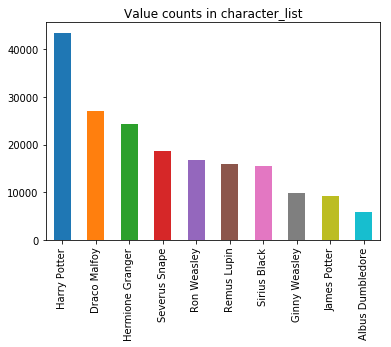

In [40]:
%matplotlib inline
# Graph distribution of character metadata

n_rows = 10
f = 'hp'
col = 'character_list'
top = pd.Series(Counter([val for line in metadata[f][col].tolist() for val in line if len(val) > 0]))
top = top.sort_values(ascending=False).head(10)
top.plot.bar().set_title(f'Value counts in {col}')
top.plot.bar()

# Look into convention for grouping works by ID

## Explore IDs

In [2]:
# Load data
# data_dirpath = '/usr2/mamille2/AO3Scraper/data/percy_jackson_fics.csv_text_files/' # AO3 Percy Jackson
# data_dirpath = '/usr2/mamille2/AO3Scraper/data/hp_fics.csv_text_files/' # AO3 HP
data_dirpath = '/usr2/mamille2/fanfiction-project/data/hp/stories' # ff.net HP

ids = [i for i in os.listdir(data_dirpath)]
print(len(ids))
print(min(len(i) for i in ids))
print(max(len(i) for i in ids))

558239
7
12


In [3]:
# How many groups if took prefix of n chars
thresholds = [2,3,4]
for n in thresholds:
    print(n)
    gps = defaultdict(list)
    
    for i in ids:
        gps[i[:n]].append(i)

    print(f'#groups: {len(gps)}')
    print(f'#stories in biggest group: {max(len(gps[i]) for i in gps)}')
    print()

2
#groups: 90
#stories in biggest group: 37866

3
#groups: 900
#stories in biggest group: 4439

4
#groups: 9001
#stories in biggest group: 532



In [4]:
# Create directories for stories, move them 
fandoms = ['lotr', 'hunger_games', 'hp', 'twilight', 'percy_jackson']
threshold = 3
for f in fandoms:
    tqdm.write(f)
#     data_dirpath = f'/usr2/mamille2/AO3Scraper/data/{f}_fics.csv_text_files/' # AO3
    data_dirpath = f'/usr2/mamille2/fanfiction-project/data/{f}/stories' # FF.net
    ids = [i for i in os.listdir(data_dirpath)]
    
    for i in tqdm(ids):
        shortened = i[:threshold]
        old_fpath = os.path.join(data_dirpath, i)
        new_fpath = os.path.join(data_dirpath, shortened, i)
#         id_dirpath = os.path.join(data_dirpath, shortened)
#         if not os.path.exists(id_dirpath):
#             os.makedirs(id_dirpath)
        os.renames(old_fpath, new_fpath)

# Create authorship attribution dataset from incomplete FF.net 3+ stories

In [2]:
# Load data
# metadata = pd.read_csv('/usr2/mamille2/AO3Scraper/hp_metadata.csv')
metadata = pd.read_csv('/usr2/mamille2/fanfiction-project/data/hp/hp_ff-net_metadata_incomplete.csv')
print(metadata.shape)
print(metadata.columns)

(350888, 14)
Index(['id', 'canon_type', 'canon', 'author_id', 'title', 'updated',
       'published', 'lang', 'genres', 'num_reviews', 'num_favs', 'num_follows',
       'num_words', 'rated'],
      dtype='object')


In [6]:
author_story_counts.head()

2861617    636
981007     547
924518     513
941781     483
2648815    453
Name: author_id, dtype: int64

In [7]:
len(author_story_counts)

128871

In [8]:
len(metadata['author_id'].unique())

128871

In [15]:
threshold = 10
author_story_counts = metadata['author_id'].value_counts()
author_ids = sorted(set(author_story_counts[author_story_counts >= threshold].index))
len(author_ids)

5204

In [26]:
# Load matching stories
stories = []
story_dirpath = '/usr2/mamille2/fanfiction-project/data/hp/stories/'

for a_id in tqdm(author_ids):
    story_ids = metadata.loc[metadata['author_id']==a_id, 'id'].tolist()
    author_text = ''
    for s_id in story_ids:
        with open(os.path.join(story_dirpath, f'{s_id}.txt')) as f:
            author_text += f'{f.read()}\n'
            
    stories.append(author_text)
    
len(stories)

5204

In [33]:
# Vectorize
vec = CountVectorizer(max_features=50000)
X = vec.fit_transform(stories)
X.shape

(5204, 50000)

In [34]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, author_ids)

In [35]:
# Train, evaluate classifier
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
preds = clf.predict(X_test)


# Check author/#works curve

In [2]:
# Load data
# metadata = pd.read_csv('/usr2/mamille2/AO3Scraper/hp_metadata.csv')
metadata = pd.read_csv('/usr2/mamille2/fanfiction-project/data/hp/hp_ff-net_metadata_incomplete.csv')
print(metadata.shape)
print(metadata.columns)

(350888, 14)
Index(['id', 'canon_type', 'canon', 'author_id', 'title', 'updated',
       'published', 'lang', 'genres', 'num_reviews', 'num_favs', 'num_follows',
       'num_words', 'rated'],
      dtype='object')


In [6]:
n_unique = len(metadata['author_id'].unique())
print(n_unique)
print(len(metadata)/n_unique)

128871
2.72278480030418


In [3]:
# Basic stats
work_counts = metadata['author_id'].value_counts().value_counts()

print(work_counts[1]/work_counts.sum())

work_counts.loc[3:,].sum()

0.591490715522


30712

In [4]:
work_counts.head()

1    76226
2    21933
3    10159
4     5635
5     3585
Name: author_id, dtype: int64

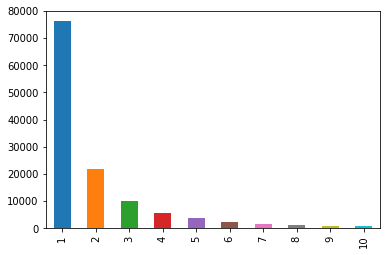

In [9]:
%matplotlib inline

work_counts.head(10).plot.bar()

# Check for 'projecting' tags

In [2]:
# Load data
metadata = pd.read_csv('/usr2/mamille2/AO3Scraper/hp_metadata_incomplete.csv')
print(metadata.shape)
print(metadata.columns)

(65528, 19)
Index(['Unnamed: 0', 'work_id', 'title', 'rating', 'category', 'fandom',
       'relationship', 'character', 'additional tags', 'language', 'published',
       'status', 'status date', 'words', 'chapters', 'comments', 'kudos',
       'bookmarks', 'hits'],
      dtype='object')


In [3]:
metadata['additional_tags_list'] = metadata['additional tags'].str.split(',\s+')
metadata['additional_tags_list'].head()

0    [Humor, Romance, Hogwarts Eighth Year, HP: EWE...
1        [Hogwarts Eighth Year, Humor, Romance, Fluff]
2    [Slow Build, Draco-centric, Tea Drinking, Swea...
3    [HP: EWE, Hogwarts Eighth Year, Romance, Myste...
4    [Hogwarts Eighth Year, Some Homophobia in the ...
Name: additional_tags_list, dtype: object

In [11]:
term = 'Projecting'
term_in_tags = metadata[metadata['additional_tags_list'].map(lambda x: any(term in t) if isinstance(x, list) else False)]
len(term_in_tags)

0

# Extract just metadata from AO3 CSVs

In [2]:
fandoms = [
#     'hp', 
    'twilight', 'percy_jackson', 
    'lotr', 
    'hunger_games',
]

for f in tqdm(fandoms):
#     data = pd.read_csv(f'/usr2/mamille2/AO3Scraper/{f}_fics.csv')
    data = pd.read_csv(f'/usr2/mamille2/AO3Scraper/data/{f}_fics_author.csv')
    metadata = data.loc[:, [col for col in data.columns.tolist() if col != 'body']]
    metadata.to_csv(f'/usr2/mamille2/AO3Scraper/data/{f}_ao3_metadata.csv')

# Explore HP AO3 data

In [2]:
data = pd.read_csv('/usr2/mamille2/AO3Scraper/hp_fics.csv')
print(data.shape)
data.columns

(62428, 19)


Index(['work_id', 'title', 'rating', 'category', 'fandom', 'relationship',
       'character', 'additional tags', 'language', 'published', 'status',
       'status date', 'words', 'chapters', 'comments', 'kudos', 'bookmarks',
       'hits', 'body'],
      dtype='object')

In [4]:
pd.set_option('display.max_colwidth', -1)

In [7]:
metadata = data.loc[:, [col for col in data.columns.tolist() if col != 'body']]
metadata.head()

,work_id,title,rating,category,fandom,relationship,character,additional tags,language,published,status,status date,words,chapters,comments,kudos,bookmarks,hits
0,234222,Then Comes a Mist and a Weeping Rain,Explicit,M/M,Harry Potter - J. K. Rowling,Draco Malfoy/Harry Potter,"Harry Potter, Draco Malfoy, Gregory Goyle, Millicent Bulstrode, Ernie Macmillan, Hermione Granger, Ron Weasley","Humor, Romance, Hogwarts Eighth Year, HP: EWE, Post - Deathly Hallows, Complete",English,2011-08-04,Completed,2011-08-04,21139,1/1,462.0,21818,4889.0,272496.0
1,485218,Storm in a Teacup,Mature,M/M,Harry Potter - J. K. Rowling,Draco Malfoy/Harry Potter,Draco Malfoy,"Hogwarts Eighth Year, Humor, Romance, Fluff",English,2012-08-13,Completed,2012-08-13,7954,1/1,254.0,15232,2738.0,156172.0
2,2734082,Tea and No Sympathy,Explicit,M/M,Harry Potter - J. K. Rowling,Draco Malfoy/Harry Potter,"Narcissa Malfoy, Lucius Malfoy, Hermione Granger, Ron Weasley, Aberforth Dumbledore, Rubeus Hagrid, Buckbeak, Justin Finch-Fletchley, Ernie Macmillan, Terence Higgs, Minerva McGonagall, Giant Squid (Harry Potter)","Slow Build, Draco-centric, Tea Drinking, Swearing, Muggle London, Houses of Parliament, Malfoy Manor, flangst, Family Feels, Muggle/Wizard Relations, Coming Out, Heartfelt Conversations, Sarcastic Conversations, Owls, Competitive Card Games, Falling In Love, getting drunk, Enthusiastic Snogging, Hogwarts Castle, Sex In The Slytherin Dormitory, Frottage, Time Travel, Time Loop, HP: EWE",English,2014-12-23,Completed,2014-12-23,70045,11/11,844.0,14391,4021.0,200176.0
3,1439476,An Issue of Consequence,Explicit,M/M,Harry Potter - J. K. Rowling,Draco Malfoy/Harry Potter,"Draco Malfoy, Harry Potter, Blaise Zabini, Pansy Parkinson","HP: EWE, Hogwarts Eighth Year, Romance, Mystery, Humor, Explicit Sexual Content, Potions",English,2014-04-09,Completed,2014-04-15,20798,5/5,395.0,14273,2587.0,215635.0
4,3101099,The Standard You Walk Past,Mature,M/M,Harry Potter - J. K. Rowling,"Draco Malfoy/Harry Potter, Hermione Granger/Ron Weasley (side), Lucius Malfoy/Narcissa Malfoy (side)","Draco Malfoy, Harry Potter, Hermione Granger, Ron Weasley, Narcissa Black Malfoy, Pansy Parkinson, Mentions of many characters","Hogwarts Eighth Year, Some Homophobia in the Wizarding World, Romance, Friends to Lovers, Fluff, flangst, Angst, SO MUCH FLUFF, And a bit of sap, Legilimency, Dreams and Nightmares, Slow Build, Prejudice against Slytherins",English,2015-01-04,Completed,2015-03-12,46202,14/14,1331.0,14154,2868.0,195822.0


In [8]:
type(metadata.loc[0, 'character'])

str

In [14]:
def split_column(val):
    if isinstance(val, str):
        ans = val.split(', ')
    else:
        ans = []
        
    return ans

In [18]:
val_cols = ['category', 'fandom', 'relationship', 'character', 'additional tags']
for col in val_cols:
    print(col)
    data[f'{col}_list'] = list(map(split_column, tqdm(data[col])))
    
data.columns

category


fandom


relationship


character


additional tags


Index(['work_id', 'title', 'rating', 'category', 'fandom', 'relationship',
       'character', 'additional tags', 'language', 'published', 'status',
       'status date', 'words', 'chapters', 'comments', 'kudos', 'bookmarks',
       'hits', 'body', 'category_list', 'fandom_list', 'relationship_list',
       'character_list', 'additional tags_list'],
      dtype='object')

## Graph most popular category values

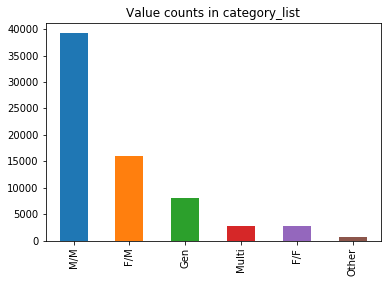

In [61]:
# for col in val_cols:
col = val_cols[0] + '_list'
n_rows = 10
# top = data[col].value_counts().head(10)
# top = data[col].apply(lambda x: pd.Series(x).value_counts()).sum().head(10)
# top = data[col].apply(lambda x: pd.Series(x).value_counts()) # Takes forever

top = pd.Series(Counter([val for line in data[col].tolist() for val in line]))
top = top.sort_values(ascending=False).head(n_rows)
top.plot.bar().set_title(f'Value counts in {col}')
top.plot.bar()

#     top.plot.bar().get_figure().savefig(
#         f'/usr2/mamille2/AO3Scraper/output/{col.replace(" ","_")}_values.png')

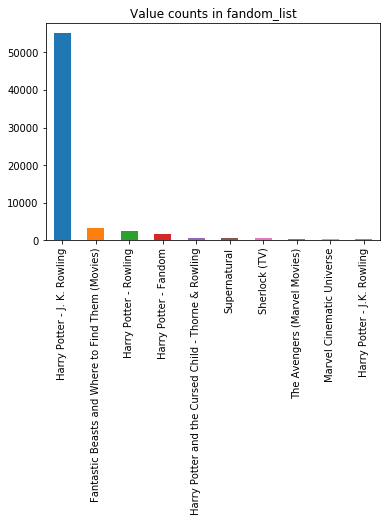

In [62]:
# for col in val_cols:
col = val_cols[1] + '_list'
n_rows = 10
# top = data[col].value_counts().head(10)
# top = data[col].apply(lambda x: pd.Series(x).value_counts()).sum().head(10)
# top = data[col].apply(lambda x: pd.Series(x).value_counts()) # Takes forever

top = pd.Series(Counter([val for line in data[col].tolist() for val in line]))
top = top.sort_values(ascending=False).head(n_rows)
top.plot.bar().set_title(f'Value counts in {col}')
top.plot.bar()

#     top.plot.bar().get_figure().savefig(
#         f'/usr2/mamille2/AO3Scraper/output/{col.replace(" ","_")}_values.png')

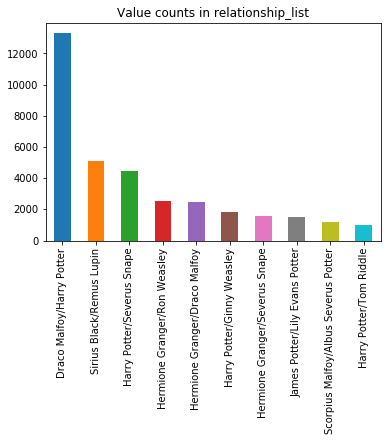

In [63]:
# for col in val_cols:
col = val_cols[2] + '_list'
n_rows = 10
# top = data[col].value_counts().head(10)
# top = data[col].apply(lambda x: pd.Series(x).value_counts()).sum().head(10)
# top = data[col].apply(lambda x: pd.Series(x).value_counts()) # Takes forever

top = pd.Series(Counter([val for line in data[col].tolist() for val in line]))
top = top.sort_values(ascending=False).head(n_rows)
top.plot.bar().set_title(f'Value counts in {col}')
top.plot.bar()

#     top.plot.bar().get_figure().savefig(
#         f'/usr2/mamille2/AO3Scraper/output/{col.replace(" ","_")}_values.png')

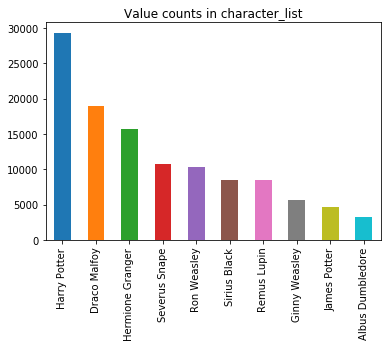

In [64]:
# for col in val_cols:
col = val_cols[3] + '_list'
n_rows = 10
# top = data[col].value_counts().head(10)
# top = data[col].apply(lambda x: pd.Series(x).value_counts()).sum().head(10)
# top = data[col].apply(lambda x: pd.Series(x).value_counts()) # Takes forever

top = pd.Series(Counter([val for line in data[col].tolist() for val in line]))
top = top.sort_values(ascending=False).head(n_rows)
top.plot.bar().set_title(f'Value counts in {col}')
top.plot.bar()

#     top.plot.bar().get_figure().savefig(
#         f'/usr2/mamille2/AO3Scraper/output/{col.replace(" ","_")}_values.png')

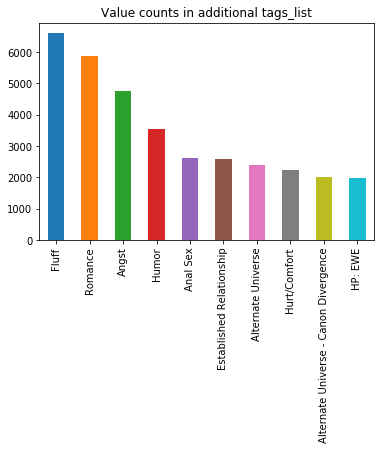

In [65]:
# for col in val_cols:
col = val_cols[4] + '_list'
n_rows = 10
# top = data[col].value_counts().head(10)
# top = data[col].apply(lambda x: pd.Series(x).value_counts()).sum().head(10)
# top = data[col].apply(lambda x: pd.Series(x).value_counts()) # Takes forever

top = pd.Series(Counter([val for line in data[col].tolist() for val in line]))
top = top.sort_values(ascending=False).head(n_rows)
top.plot.bar().set_title(f'Value counts in {col}')
top.plot.bar()

#     top.plot.bar().get_figure().savefig(
#         f'/usr2/mamille2/AO3Scraper/output/{col.replace(" ","_")}_values.png')

In [68]:
col = val_cols[0]
data[col].str.split(',\s+')

0        [M/M]     
1        [M/M]     
2        [M/M]     
3        [M/M]     
4        [M/M]     
5        [M/M]     
6        NaN       
7        [M/M]     
8        [M/M]     
9        [M/M]     
10       [M/M]     
11       [M/M]     
12       [M/M]     
13       [M/M]     
14       [M/M]     
15       [M/M]     
16       [M/M]     
17       [M/M]     
18       [Multi]   
19       [M/M]     
20       [M/M]     
21       [M/M]     
22       [M/M]     
23       [M/M]     
24       [Gen]     
25       [M/M]     
26       [M/M]     
27       [M/M]     
28       [M/M]     
29       [M/M]     
         ...       
62398    [F/M, Gen]
62399    [M/M]     
62400    [F/F]     
62401    [M/M]     
62402    [M/M]     
62403    [M/M]     
62404    [F/M]     
62405    [F/M]     
62406    [F/M, M/M]
62407    [F/M]     
62408    [Gen]     
62409    [M/M]     
62410    [M/M]     
62411    NaN       
62412    [F/M]     
62413    [M/M]     
62414    [Multi]   
62415    [M/M]     
62416    [M/M]     
